# **INTEGRANTES DO GRUPO:**

* Alexandre Ferreira - RM 565626
* Carlos Bucker - RM 555812
* Luca Tiepolo Schmidt Morete - RM 560255
* Filipe Melo - RM 564571
* Mayara Mota - RM 563887

# **1. INTRODUÇÃO**

## *1.1 Contextualização do problema*

No contexto da empresa SOMPO que atua com seguros de transporte de cargas, compreender e antecipar os riscos de roubo e acidentes de carga é fundamental principalmente dentro das rodovias do Brasil. Nós do grupo Webscrapers, observamos que existem dificuldades e incorformidades em trajetos e trechos rodoviários e acreditamos que existem também imprevisibilidade dos acidentes e isso são fatores que comprometem o transporte seguro de carga.

Os roubos e acidentes de cargas podem ser evitados ou pelo menos reduzidos, pois podemos intervir e direcionar algumas soluções justamente onde ocorre o problema, dentro do próprio trajeto ou trecho que a carga vai passar. E assim, é possível preservar todo o investimento que foi feito e fortalecer a confiança do cliente no serviço que foi prestado.

Ao pensar nesses detalhes, foi estruturado um projeto que utiliza redes neurais recorrentes do tipo LSTM, para **prever a probabilidade de ocorrência de acidentes em determinado período nas rodovias brasileiras.**

O grupo analisou o processo que foi desenvolvido e observou que essa proposta de criar redes neurais iria também possibilitar a criação de um modelo que pode alertar de forma antecipada os trechos e períodos com maior risco de roubo ou acidente,melhorando a estratégia de ação e a tomada de decisão da empresa.


## *1.2 Justificativa e relevância do problema*

O projeto utilizou o dataset disponibilizado pela Polícia Rodoviária Federal presente no site: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf

O banco de dados foi o "Documento CSV de Acidentes 2025 (Agrupados por ocorrência)", um documento atual, desse ano, que vai mostrar justamente o que precisamos saber sobre a ocorrência de acidentes em um período específico. Sendo um documento que mostra informações reais com presença de variáveis de tempo e comportamento, ideais para que o modelo aprenda padrões temporais e comportamentais de acidentes.

**E uma vez que compreendemos o que influencia os acidentes nas rodovias, podemos entender que esses fatores também podem ser motivos para a ocorrência de roubo de carga.**

E uma das perguntas que trouxe impacto em muitos pensamentos do nosso grupo e que impulsionou as estrégios do projeto foi a seguinte:

É possível prever com antecedência os momentos e locais onde há maior chance de ocorrer um acidente nas rodovias brasileiras?

## *1.3 Objetivo*

O objetivo do projeto construir um modelo de rede neural LSTM capaz de prever aspectos relacionados a acidentes de trânsito a partir de séries temporais e variáveis contextuais.

**O target do problema escolhido foi a probabilidade de ocorrência de acidentes em determinado período.**

# **2. VALIDAÇÃO DA INTEGRIDADE DO DATASET**

## *2.1 Setup do ambiente*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## *2.2 Conhecendo o dataset*

In [ ]:
# Lendo o arquivo CSV
df = pd.read_csv('datatran2025.csv', sep=';', encoding='latin-1', low_memory=False)

# Atenção: O datset vem separada por ; e com acentuação, então é necessário usar sep=';' e encoding='latin-1'

In [ ]:
# Visualizar as primeiras linhas
df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,652493,2025-01-01,quarta-feira,06:20:00,SP,116,225,GUARULHOS,Reação tardia ou ineficiente do condutor,Tombamento,...,0,0,1,1,2,"-23,48586772","-46,54075317",SPRF-SP,DEL01-SP,UOP01-DEL01-SP
1,652519,2025-01-01,quarta-feira,07:50:00,CE,116,"546,2",PENAFORTE,Pista esburacada,Colisão frontal,...,0,1,4,1,6,"-7,812288","-39,08333306",SPRF-CE,DEL05-CE,UOP03-DEL05-CE
2,652522,2025-01-01,quarta-feira,08:45:00,PR,369,"88,2",CORNELIO PROCOPIO,Reação tardia ou ineficiente do condutor,Colisão traseira,...,0,2,0,3,2,"-23,182565","-50,637228",SPRF-PR,DEL07-PR,UOP05-DEL07-PR
3,652544,2025-01-01,quarta-feira,11:00:00,PR,116,74,CAMPINA GRANDE DO SUL,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,...,0,4,0,1,2,"-25,36517687","-49,04223028",SPRF-PR,DEL01-PR,UOP02-DEL01-PR
4,652549,2025-01-01,quarta-feira,09:30:00,MG,251,471,FRANCISCO SA,Velocidade Incompatível,Colisão frontal,...,1,1,2,2,4,"-16,46801304","-43,43121303",SPRF-MG,DEL12-MG,UOP01-DEL12-MG


Nessa tabela, cada linha é um registro individual de acidente em uma rodovia e cada coluna traz uma informação sobre o acidente.

Na linha 0, observamos: O número do ID, a data que aconteceu que foi no dia 1º de janeiro de 2025, um feriado, no horário de 06:20 da manhã, em uma quarta-feira, em SP na BR 116, uma das principais rodovias, no minicípio de Guarulhos, o acidente que aconteceu foi um tombamento por causa de uma reação tardia ou ineficiente do motorista, não teve vitima com ferimentos graves, uma pessoa foi ferida, o acidente envolveu 2 veículos.

E na linha 4, observamos: o número do ID, a data foi também no dia 1º de janeiro de 2025, aconteceu às 09:30, foi em Minas Gerais, na BR 225, no município Francisco Sá, , o acidnete foi uma colisão frontal e a causa a velocidade que estava incompatível, pelo menos uma pessoa ficou ferida gravemente, o acidente envolveu 2 pessoas e 4 veículos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53213 entries, 0 to 53212
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      53213 non-null  int64 
 1   data_inversa            53213 non-null  object
 2   dia_semana              53213 non-null  object
 3   horario                 53213 non-null  object
 4   uf                      53213 non-null  object
 5   br                      53213 non-null  int64 
 6   km                      53213 non-null  object
 7   municipio               53213 non-null  object
 8   causa_acidente          53213 non-null  object
 9   tipo_acidente           53213 non-null  object
 10  classificacao_acidente  53212 non-null  object
 11  fase_dia                53213 non-null  object
 12  sentido_via             53213 non-null  object
 13  condicao_metereologica  53213 non-null  object
 14  tipo_pista              53213 non-null  object
 15  tr

Existem 53.213 registros, ou seja, são 53.213 acidentes acorridos no dataset com 30 colunas, dessas 30 colunas 10 são do tipo inteira e 20 colunas são do tipo objetivo que expressam textos.

A maioria das colunas estão preenchidas com o total de 53.213, mas tem algumas que possuem dados faltando como coluna 10 que é a classificação de acidente com 53.212 , a coluna 27  que é a regional com 53.211, a coluna 28 que é a delegacia com 53.197 e a coluna 29 que é a uop com 53.187.

In [ ]:
print(df.columns.tolist())

['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio', 'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional', 'delegacia', 'uop']


Aqui, nós conhecemos exatamente como cada coluna está escrita no dataset, pois para estruturar os códigos devemos escrever exatamente como aparece no dataset para não ter erro.

In [ ]:
df.describe()

,id,br,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
count,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000,53213.000000
mean,689146.658617,208.592224,2.591923,0.084058,0.872080,0.275008,1.051566,0.398211,1.147088,2.006746
std,21556.317110,128.496370,2.205364,0.336491,1.028883,0.607489,1.780304,0.890007,1.136842,1.149654
min,652468.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,667471.000000,101.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,693306.000000,156.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000
75%,707792.000000,319.000000,3.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,725899.000000,495.000000,76.000000,11.000000,41.000000,22.000000,71.000000,81.000000,49.000000,82.000000


Aqui nessa tabela, como faz a análise da estatística descritiva, só irá envolver as colunas são numéricas, do tipo inteiras. Então:

Em relação à quantidade de pessoas envolvidas em acidentes, observamos, em média tem 2 até 2.59 ou até 3 pessoas, mostrando que os em média a maioria dos acidentes envolvem transportes pequenos ou particulares, o desvio padrão tem o valor de 2.20 um pouco perto da média que é 2.59 mostrando que varia muito a quantidade de pessoas envolvidas, em relação ao mínimo tem 1 pessoa envolvida e em relação ao máximo tem 76 pessoas envolvidas, em 25% dos acidentes envolvem 2 pessoas, em 50% dos acidentes envolve 2 pessoas e em 75% dos acidentes envolve 3 pessoas.

Em relação aos acidentes que tiveram óbitos, observamos, em média 0,084 onde a cada 100 acidentes 8 acidentes resultam em obito, o desvio padrão é de 0,3 tendo uma variação baixa, os valores minimos são 0.0 sem óbito e valores máximo indicam que teve acidentes com 11 pessoas que foram à óbito, em 25%, 50% e 75% dos acidnetes não tiveram óbito.

Em relação aos acidentes graves que tiveram a presença de pessoas com feridas graves, observamos que a média foi de 0.27, isso significa que se existem 53.213 acidentes e se eu multiplicar esse valor com 0.27, eu tenho 14.134 pessoas feridas gravemente, o desvio padrão é de 0.60 que é baixo a moderado, o valor mínimo é 0.0 que indica que a maioria dos acidentes não tem feridos graves, o valor máximo mostra 22 indicando que existiram acidentes com ate 22 pessoas com ferimentos graves

Em relação aos veículos envolvidos nos acidentes, observamos que em média tem 2 veículos envolvidos em acidentes, o desvio padrão é de 1.14, o valor mínimo é 1 indicando que pelo menos 1 veículo é envolvido em acidente e máximo é 82, isso é um valor alto, extremo que pode até mostrar outliers. Como a média mostra que pelo menos 2 veículos sao envolvidos em acidentes, um acidente com 84 veículos envolvidos está fora do padrão de distribuição.

# **3. LIMPEZA E PADRONIZAÇÃO DO DATASET**

Nessa etapa vai ser realizada a limpeza, padronização e estruturação do dataset.

Primeiramente, vamos remover os espaços em branco usando o "strip" e transformar todos os nomes das colunas em letras minúsculas com "lower". E como pode existir diferença e erros nas palavras do dataset vai ser necessário padronizar.

Uma coluna que será importante para a nossa análise de padrão temporal é a "data_inversa", pois contém informação da data, variável necessária para prever a probabilidade de ocorrência de acidentes em determinado período. E a limpeza dessa coluna vai garantir que os registros tenham datas válidas.

Foi preciso escolher as colunas que iríamos usar, pois como são muitas, escolhemos apenas aquelas que vao influenciar no aprendizado do modelo. As colunas que não trazem muito impacto para o nosso projeto sao as IDs, placas, descrição do veículo, enquanto as colunas como data, uf, km, fase_dia, condição meteorológica, são variáveis que interferem muito na resposta do modelo e são ideais para serem usadas pois darão bons resultados.

Nesse sentido, arredondar os valores de km e agrupar alguns trechos próximos podem ser interessante porque acidentes próximos podem ter acontecido no mesmo trecho da rodovia.

E contar acidentes que acontecem no dia em cada trecho também seria necessário, pois iremos identificar o trecho que possui a maior quantidade de acidente.

Como nós vamos identificar se ocorreu ou não acidentes em um determinado período, sabemos que essa variável é binária. Então teremos:

0 para nenhum acidente e
1 para pelo menos um acidente


E algo importante que faz sentido para analisar no nosso projeto que é prever a propabilidade de acidentes em um determinado período, pensamos em saber qual é o trecho que tem o maior numero de acidentes e assim treinar e visualizar o comportamento desse trecho especificamente e assim conhecer a ocorrência de acidentes ao logo do tempo desse mesmo trecho. Então a nossa série temporal será construída em cima desse trecho.

Se nós vamos criar um modelo que precisa de uma sequencia regular de tempo, não pode ter datas faltando nesse modelo porque se nao o modelo não consegue interpretar a dinâmica de tempo. Logo, é necessário preencher os dias que estão falatando, caso exista




In [ ]:
# === LIMPEZA E PREPARAÇÃO ===

# padronizar nomes de colunas
df.columns = [c.strip().lower() for c in df.columns]

# converter data
df['data'] = pd.to_datetime(df['data_inversa'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['data'])

# selecionar colunas de interesse
cols = ['data', 'uf', 'br', 'km', 'municipio', 'fase_dia', 'condicao_metereologica', 'tipo_pista']
df = df[cols]

# converter a coluna km para numérico
df['km'] = df['km'].astype(str).str.replace(',', '.').astype(float)

# criar uma chave para o local aproximado (trecho)
df['km_round'] = df['km'].round().astype('Int64')
df['trecho'] = df['uf'].astype(str) + "_" + df['br'].astype(str) + "_" + df['km_round'].astype(str)

# Contar acidentes por dia em cada trecho
daily = df.groupby(['trecho', 'data']).size().reset_index(name='num_acidentes')

# converter para formato binário (houve ou não acidente)
daily['acidente_ocorreu'] = (daily['num_acidentes'] > 0).astype(int)

# criar série temporal completa para um trecho de exemplo
trecho_exemplo = daily['trecho'].value_counts().idxmax()
serie = daily[daily['trecho'] == trecho_exemplo][['data','acidente_ocorreu']].set_index('data')

# preencher dias sem acidentes (0)
full_index = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='D')
serie = serie.reindex(full_index, fill_value=0)
serie.index.name = 'data'

print(f"Série temporal do trecho {trecho_exemplo}:")
serie.head(10)


Série temporal do trecho SP_116_219:


,acidente_ocorreu
data,
2025-01-02,1
2025-01-03,0
2025-01-04,0
2025-01-05,0
2025-01-06,0
2025-01-07,0
2025-01-08,0
2025-01-09,0
2025-01-10,0


Aqui está a estrutura da série temporal, onde cada linha representa um dia.

Existe a coluna "data" e a coluna "acidente_ocorreu"  que é o target que o modelo vai prever. Onde 0 = não houve acidente naquele dia e 1 = houve acidente.

O modelo LSTM vai aprender padrões temporais, por exemplo:

Depois de uma sequência de 7 dias sem acidentes, qual é a probabilidade de ocorrer um acidente no próximo dia? E é isso que será desenvolvido mais a diante.





Porém antes de iniciar a construção do modelo, vamos identificar qual trecho realmente possui mais acidentes, entao irems descobrir qual possui o maior número de registros.

Poderíamos escolher qualquer trecho, mais escolhemos o de maior número de acidentes e por que para o nosso projeto é importante escolher esse trecho? Porque quando existe uma quantidade maior de informação, a sequencia temporal será mais longa e consistente.

E por isso, iremos conhecer quais trechos existem no nosso dataset e quantos registros de acidentes cada trecho tem.



In [ ]:
# contar quantos registros há por trecho
contagem_trechos = daily['trecho'].value_counts().reset_index()
contagem_trechos.columns = ['trecho', 'quantidade_registros']

# mostrar as 10 maiores ocorrências
print(contagem_trechos.head(10))

       trecho  quantidade_registros
0  SP_116_219                    22
1  SC_101_208                    21
2  SP_116_224                    19
3  SC_101_205                    18
4  ES_101_270                    18
5  SP_116_227                    18
6  ES_101_268                    18
7  SC_101_214                    17
8  SC_101_216                    17
9  SC_101_202                    17


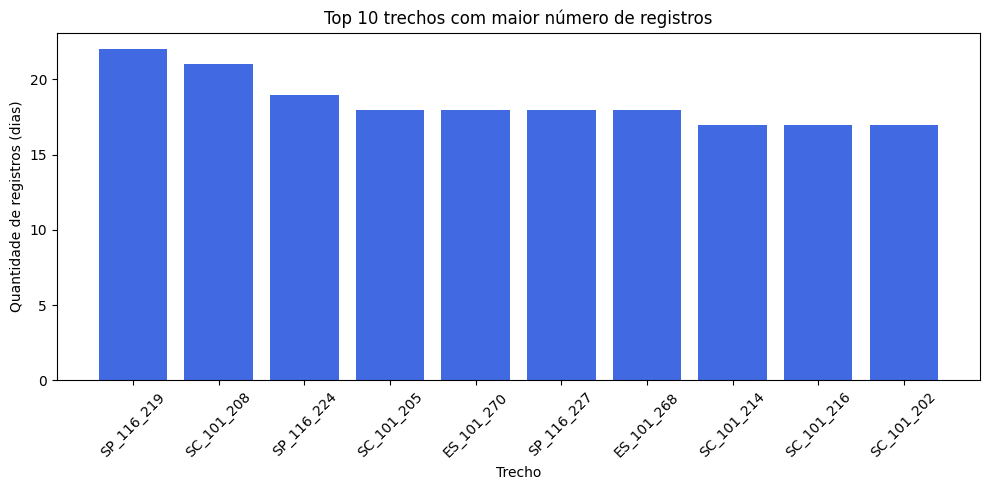

In [ ]:
import matplotlib.pyplot as plt

top_trechos = contagem_trechos.head(10)
plt.figure(figsize=(10,5))
plt.bar(top_trechos['trecho'], top_trechos['quantidade_registros'], color='royalblue')
plt.xticks(rotation=45)
plt.title('Top 10 trechos com maior número de registros')
plt.xlabel('Trecho')
plt.ylabel('Quantidade de registros (dias)')
plt.tight_layout()
plt.show()

Nos dois resultados, tanto na tabela quanto no gráfico,  é possível observar que o trecho SP_116_119 possui 22 acidentes , o trecho SP_101_208 possui 21 acidentes e o trecho SC_101_202 possui 17 acidentes.

# **4. CRIAR FEATURES E SEQUÊNCIA TEMPORAL**

In [ ]:
# === FEATURES ===
serie['dayofweek'] = serie.index.dayofweek
serie['month'] = serie.index.month
serie['weekofyear'] = serie.index.isocalendar().week.astype(int)

# codificação cíclica
serie['dow_sin'] = np.sin(2*np.pi*serie['dayofweek']/7)
serie['dow_cos'] = np.cos(2*np.pi*serie['dayofweek']/7)
serie['month_sin'] = np.sin(2*np.pi*serie['month']/12)
serie['month_cos'] = np.cos(2*np.pi*serie['month']/12)

features = ['dow_sin','dow_cos','month_sin','month_cos']
target = 'acidente_ocorreu'

data = serie[features + [target]].copy().values

# variáveis de configuração
SEQ_LEN = 7        # janela de 7 dias para prever o próximo
TEST_RATIO = 0.2   # 20% dos dados para teste
VAL_RATIO = 0.1    # 10% dos dados para validação

# === GERAR SEQUÊNCIAS ===
def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data, SEQ_LEN)
print("Shape X:", X.shape, "y:", y.shape)

# dividir em treino/val/test
n = len(y)
test_n = int(TEST_RATIO * n)
val_n = int(VAL_RATIO * n)

X_train, y_train = X[:-(test_n+val_n)], y[:-(test_n+val_n)]
X_val, y_val = X[-(test_n+val_n):-test_n], y[-(test_n+val_n):-test_n]
X_test, y_test = X[-test_n:], y[-test_n:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Shape X: (334, 7, 4) y: (334,)
Train: (235, 7, 4) Val: (33, 7, 4) Test: (66, 7, 4)


O Shape X significa os dados de entrada do modelo (334, 7, 4).

- 334 é o número total de janelas temporais, ou seja, de sequências criadas.

- 7 é comprimento da sequência temporal, ou seja, o modelo usa 7 dias e vai prever o 8º dia.

- 4 é o número de variáveis de entrada, as features, usadas em cada dia. Nesse caso, as colunas são: ['dow_sin', 'dow_cos', 'month_sin', 'month_cos']

O modelo vai observar 7 dias consecutivos, e em cada dia ele vai ter 4 variáveis numéricas.

Depois, temos divisão de treino, validação e teste
Train: (235, 7, 4)
Val:   (33, 7, 4)
Test:  (66, 7, 4)


Em que no Treino tem 235 sequências para ajustar os pesos. Na Validação tem 33 sequências para monitorar o desempenho durante o treino, evitando overfitting. No Teste tem 66 sequências que serão usadas apenas no final somente para o modelo avaliar em dados que ele nunca viu antes.

E tuddo isso vem dessa definição escolhida:

- TEST_RATIO = 0.2   # 20% teste
- VAL_RATIO = 0.1    # 10% validação

A LSTM vai ser cosntruída dessa forma: tem 334 amostras temporais com janelas de 7 dias cada. Temos, dia 1 ao 7 e dentro de cada dia tem 4 variáveis e no 8º dia vai ser definido se teve acidente ou não. Depois, a LSMT vai para o próximo dia, anda um dia para frente e gera a próxima janela com 7 dias, por exemplo, Dia 2 a 8 e dentro de cada dia tem 4 variáveis e no 9º dia vai ser definido se teve acidente ou não e assim por diante até finalizar todas as amostras que são 334.



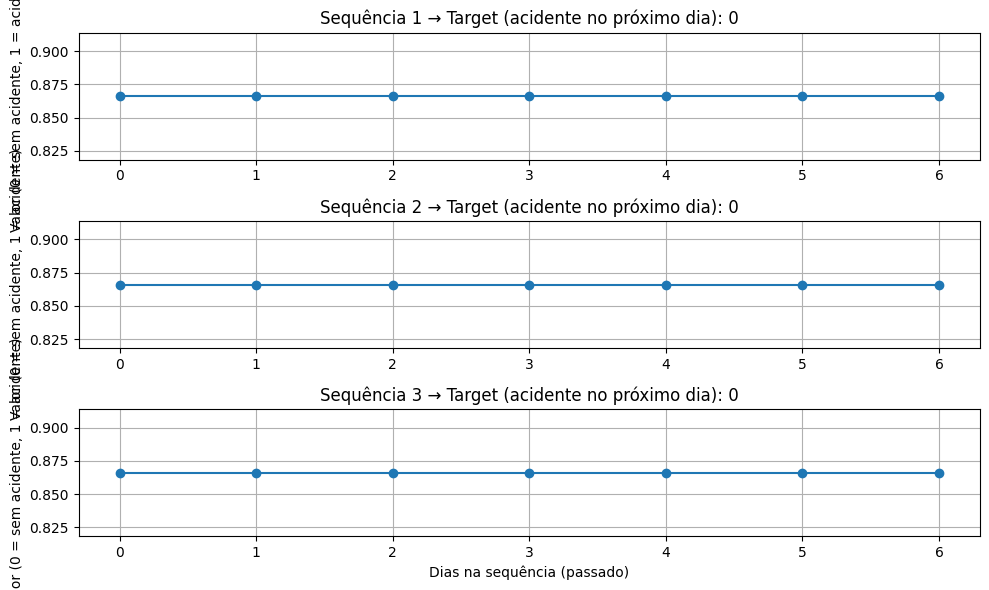

In [ ]:
# === VISUALIZAR ALGUMAS SEQUÊNCIAS TEMPORAIS ===

# número de janelas que quer visualizar
num_exemplos = 3

plt.figure(figsize=(10, 6))

for i in range(num_exemplos):
    # pegar a sequência i
    seq = X[i, :, -1] if X.shape[-1] > 0 else X[i, :]
    target = y[i]

    plt.subplot(num_exemplos, 1, i+1)
    plt.plot(seq, marker='o')
    plt.title(f"Sequência {i+1} → Target (acidente no próximo dia): {int(target)}")
    plt.ylabel("Valor (0 = sem acidente, 1 = acidente)")
    plt.grid(True)

plt.xlabel("Dias na sequência (passado)")
plt.tight_layout()
plt.show()

Cada gráfico representa uma janela de dias consecutivos usada para treinar o modelo.

- O eixo X mostra o número de dias na janela, por exemplo, os 7 dias.

O eixo Y mostra se houve acidente em cada um desses dias, usando 0 ou 1.

O título mostra o valor real que o modelo precisa prever para o dia seguinte, target.

Nos gráficos as Sequências 1, 2 e 3, apresentou vários dias sem acidente, então o modelo vai aprender que é um “padrão seguro”.Diferente se a sequência tivesse apresentado target = 1, onde iria mostrar que teve presença de acidentes e o modelo aprende que é um “padrão de risco”.

# **5. NORMALIZAR E CONSTRUIR O MODELO**

In [ ]:
# === NORMALIZAÇÃO ===
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)
def scale_seq(X):
    nsamples, seq, nf = X.shape
    return scaler.transform(X.reshape(-1, nf)).reshape(nsamples, seq, nf)

X_train_s = scale_seq(X_train)
X_val_s = scale_seq(X_val)
X_test_s = scale_seq(X_test)

# === MODELO LSTM BINÁRIO ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X_train.shape[-1])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# === TREINAMENTO ===
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_s, y_train, validation_data=(X_val_s, y_val),
                    epochs=100, batch_size=16, callbacks=[es], verbose=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 - 5s - 302ms/step - accuracy: 0.7702 - loss: 0.6748 - val_accuracy: 0.8788 - val_loss: 0.6346
Epoch 2/100
15/15 - 0s - 12ms/step - accuracy: 0.9574 - loss: 0.5866 - val_accuracy: 0.8788 - val_loss: 0.5100
Epoch 3/100
15/15 - 0s - 14ms/step - accuracy: 0.9574 - loss: 0.4154 - val_accuracy: 0.8788 - val_loss: 0.3790
Epoch 4/100
15/15 - 0s - 13ms/step - accuracy: 0.9574 - loss: 0.2272 - val_accuracy: 0.8788 - val_loss: 0.4051
Epoch 5/100
15/15 - 0s - 13ms/step - accuracy: 0.9574 - loss: 0.1865 - val_accuracy: 0.8788 - val_loss: 0.4471
Epoch 6/100
15/15 - 0s - 13ms/step - accuracy: 0.9574 - loss: 0.1824 - val_accuracy: 0.8788 - val_loss: 0.4440
Epoch 7/100
15/15 - 0s - 21ms/step - accuracy: 0.9574 - loss: 0.1886 - val_accuracy: 0.8788 - val_loss: 0.4551
Epoch 8/100
15/15 - 0s - 13ms/step - accuracy: 0.9574 - loss: 0.1758 - val_accuracy: 0.8788 - val_loss: 0.4567
Epoch 9/100
15/15 - 0s - 12ms/step - accuracy: 0.9574 - loss: 0.1807 - val_accuracy: 0.8788 - val_loss: 0.4662


- A primeira LSTM (64 unidades) menciona os padrões temporais de 7 dias.

- A segunda LSTM (32 unidades) faz o refinamento do aprendizado.

- As camadas Dropout (0.3) ajudam a evitar overfitting ou uma memorização excessiva.

- A camada Dense(16) aprende combinações não lineares.

- A camada final Dense(1, sigmoid) gera a probabilidade de acidente (0 a 1).

O total de parâmetros é de 30.625

Na Época 1 que é o início do aprendizado

- Accuracy (treino): 0.77

- Val_Accuracy (validação): 0.87

- Loss (treino): 0.67

- Val_Loss: 0.63

O modelo tem uma boa capacidade de aprendizado inicial, como a val_accuracy é maior que a accuracy de treino indica que o modelo ainda não decorou os dados, a função de perda (loss) está alta com 0.67, pois os pesos ainda estão sendo ajustados. Isso mostra que o modelo está aprendendo bem, sem overfitting.

Na Época 3, o modelo teve um ganho rápido de aprendizado

- Accuracy (treino): 0.95

- Val_Accuracy (validação): 0.87

- Loss (treino): 0.41

- Val_Loss: 0.37

Em três épocas, o modelo passou de 77% para 95% de acurácia no treino e isso foi um ganho muito alto.A val_accuracy permaneceu em 0.87, o que indica boa estabilidade, mas sem evolução. A perda caiu de 0.67 para 0.41, o que mostra que o modelo está ajustando os seus pesos. A Val_loss com 0.37 está próxima da loss do treino (0.41), o que ainda é um bom sinal de equilíbrio.


Na Épocas 5 a 13, o modelo teve uma parada na evolução.

- Accuracy (treino): ~0.95 constante

- Val_Accuracy (validação): ~0.87 constante

- Loss (treino): 0.18

- Val_Loss: 0.44–0.48 (aumentando)

Interpretação detalhada:

A acurácia de treino estabilizou em 95%, mostrando que o modelo decorou o conjunto de treinamento. A val_accuracy permanece constante (87%), o que significa que o modelo não está melhorando na validação, ou seja, não está aprendendo novos padrões úteis para dados novos. O val_loss começou a subir de 0.44 para 0.48, enquanto o loss de treino continua caindo para 0.18, e isso pode ser um padrão de overfitting leve. E isso pode acontecer quando a rede aprende demais os detalhes do treino, perdendo a capacidade de generalizar.



# **6. AVALIAR O MODELO**

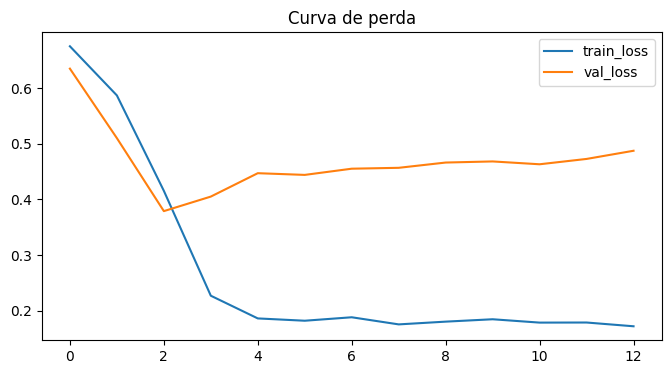

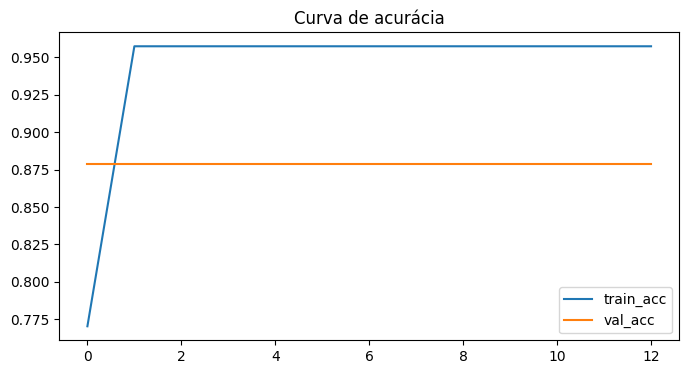

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
Accuracy: 0.894
Precision: 0.000
Recall: 0.000
F1: 0.000
ROC-AUC: 0.500

Matriz de confusão:
 [[59  0]
 [ 7  0]]


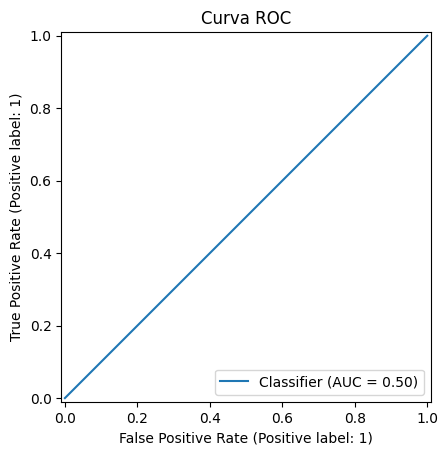

In [ ]:
# === GRÁFICOS DE TREINO ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Curva de perda'); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Curva de acurácia'); plt.show()

# === AVALIAÇÃO FINAL ===
y_pred = (model.predict(X_test_s) > 0.5).astype(int).ravel()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusão:\n", cm)

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("Curva ROC")
plt.show()


Pelo resultado, o modelo acerta 89,4% das previsões

no Precision, Recall, F1 apresentou valor =0, ou seja, o modelo não conseguiu prever nenhum caso positivo que inclui a classe 1

no ROC-AUC apresentou o valor de 0.5, ou seja, modelo não tem capacidade de separação

E na matriz de confusão: [[59, 0], [7, 0]], todas as previsões foram da classe 0, dos 7 casos positivos reais, nenhum foi identificado.

Diante disso, observa-se que o modelo só prevê a classe 0 que provavelmente é a classe em maior quantidade. E isso gera alta acurácia porque a maioria dos dados é da classe 0, mas não resolve o objetivo real da empresa, que é identificar acidentes graves de classe 1, como teve poucos exemplos da classe 1, então o modelo aprendeu a ignorá-la.

Em termos práticos, o modelo não está pronto para alertar sobre acidentes graves. Para resolver isso, precisamos ajustar o modelo para que ele aprenda melhor com os poucos casos graves, seja usando mais dados, técnicas de balanceamento ou ajustando como ele decide se um acidente é grave.

## **7. SALVAR MODELO E RESULTADO**

In [ ]:
# === SALVAR MODELO E GRÁFICOS ===
model.save("/content/modelo_acidentes.keras")
print("Modelo salvo em /content/modelo_acidentes.keras")

# gerar dataframe de resultados
results = pd.DataFrame({
    'real': y_test,
    'pred': y_pred
})
results.to_csv("/content/resultados_teste.csv", index=False)
print("Resultados exportados!")


Modelo salvo em /content/modelo_acidentes.keras
Resultados exportados!


# **6. CONCLUSÃO**

O modelo LSTM apresentou uma boa capacidade de aprendizado durante o treinamento, com 95% de acurácia, o que indica que ele conseguiu identificar padrões relevantes nos dados de acidentes.

No entanto, ao ser testado, o modelo mostrou dificuldade em reconhecer os casos de acidentes graves, classificando quase todos os exemplos como não graves. Isso ficou evidente pelas métricas de Precisão, Recall e F1-score iguais a zero, e pela matriz de confusão, que demonstrou a ausência de previsões corretas para a classe positiva.

Esse resultado revela um problema de desbalanceamento da base de dados, em que há muito mais registros de acidentes leves do que de graves. Como consequência, o modelo aprendeu a priorizar a classe mais frequente, comprometendo sua capacidade de prever corretamente os eventos mais críticos.

Para melhorar o desempenho desse projeto, teremos que aplicar técnicas de balanceamento dos dados SMOTE, ajustar o limiar de decisão do modelo e usar outros modelos que lidem melhor com classes desbalanceadas.

Assim, esse projeto não termina aqui, ele abre caminho para melhorar o seu desempenho e depois criar um sistema de monitoramento, tornando a prevenção de acidentes um diferencial na empresa SOMPO.
